In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np

from data_augmentation import data_augmentation

def triplet_formatter(data,max_triplet_len,demo=None):
    """
    Format data from np array to triplets of (timestamp, feature name, value)

    Input:
        data: np.array, N data points * len of ts * n dimension
        max_triplet_len: maximum length of triplets for each data point
        demo: np.array, N data points * n_dim_demo, demographic feature for each data point
    
    Return:
        triplet_data:
        [
            [N datapoints* demo dim], # demographic vector
            [N datapoints* max len of triplets], # timestamps
            [N datapoints* max len of triplets], # values
            [N datapoints* max len of triplets] # feature name (encoded to dummy var)
        ]
        padded with zeros if max len is not met.
        feature dummy var is the index of the dimension + 1 (start at 1)
    """
    N = len(data)

    data_idx, timestamp, feat_dummy = np.where(data!=0)

    timestamp_array = [ [] for _ in range(N) ]
    values_array = [ [] for _ in range(N) ]
    feat_dummy_array = [ [] for _ in range(N) ]

    for i,t,f in zip(data_idx,timestamp,feat_dummy):
        timestamp_array[i].append(t)
        feat_dummy_array[i].append(f+1) # feat dummy start at 1. 0 means not observed
        values_array[i].append(data[i,t,f])

    # cut each ts at max_triplet_len, then pad with zeros - shape of these arrays (N data points * max_triplet_len)
    timestamp_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in timestamp_array])
    values_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in values_array])
    feat_dummy_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in feat_dummy_array])

    if demo is None:
        demo = np.zeros((N,1))

    return [demo,timestamp_array,values_array,feat_dummy_array]


def tr_te_split(ts_data,aug_data,gt=None,tr_frac=0.8,seed=3):
    """
    Args:
        ts_data: list of lists [demo,timestamp_array,values_array,feat_dummy_array], each of these array shape (N * max_triplet_len)
        aug_data: augmented data, same format as ts_data
        gt_data: 1d np array of length N
    """
    # shuffle index and reorder based on the shuffle
    np.random.seed(seed)
    idx = np.arange(len(ts_data))
    np.random.shuffle(idx)
    ts_data = [x[idx] for x in ts_data]
    aug_data = [x[idx] for x in aug_data]
    # partition into tr and te
    tr_data = [x[:int(tr_frac*len(ts_data))] for x in ts_data]
    te_data = [x[int(tr_frac*len(ts_data)):] for x in ts_data]
    tr_aug_data = [x[:int(tr_frac*len(ts_data))] for x in aug_data]
    te_aug_data = [x[int(tr_frac*len(ts_data)):] for x in aug_data]
    # partition ground truth
    if gt:
        gt = gt[idx]
        tr_gt = gt[:int(tr_frac*len(ts_data))]
        te_gt = gt[int(tr_frac*len(ts_data)):]
    else:
        tr_gt, te_gt = None, None

    return (tr_data,tr_aug_data), tr_gt, (te_data,te_aug_data), te_gt


def read_data(
        ts_data_dir: str,
        demo_data_dir: str = None,
        gt_data_dir: str = None,
        max_triplet_len: int = 200,
        tr_te_split: str = 'no',
        tr_frac: float = 0.8,
        seed: int = 3
):  
    """
    Args:
        ts_data_dir: a pkl file when unpickled is a 3d np array (N data points * ts len * feature dim)
        demo_data_dir: a pkl file when unpickled is a 2d np array (N data points * demo_dim)
        gt_data_dir: a pkl file when unpickled is a 1d np array (N data points * 1), the gt label of the clusters
        max_triplet_len: maximum length of triplets for each data point
        tr_te_split: how to perform split 'no', or 'tr-val' or 'tr-val-te'
        tr_frac: fraction of training data
        seed: random seed

    Return:
        {'train':((tr_data,aug_data),tr_gt), 'val':(val_data,val_gt), 'test':(te_data, te_gt)}
        where tr_data and aug_data are both formatted into triplets
        gt data are 1d np array of length N
    """
    ts_data = pickle.load(open(ts_data_dir,'rb'))
    N = len(ts_data)
    full_ts_range = list(range(ts_data.shape[1]))
    n_feat = ts_data.shape[2]
    print(N,len(full_ts_range),n_feat)
    
    demo_data = None
    if demo_data_dir:
        demo_data = pickle.load(open(demo_data_dir,'rb'))
        if len(demo_data) != N:
            raise ValueError('Dimension mismatch between TS and demographic data')

    gt = None
    if gt_data_dir:
        gt = pickle.load(open(gt_data_dir),'rb')
        if len(gt) != N:
            raise ValueError('Dimension mismatch between TS and groundtruth data')

    # format and combine with demo to input data
    data = triplet_formatter(ts_data, max_triplet_len, demo_data)
    print(type(data),len(data),len(data[0]),data[1].shape)

    # data augmentation
    data, aug_data = data_augmentation(data, full_ts_range, n_feat, gen_neg=False, seed=seed)

    # train val test split
    if tr_te_split == 'tr-val':
        tr_data, tr_gt, val_data, val_gt = tr_te_split(data,aug_data,gt,tr_frac,seed)
        te_data, te_gt = None, None
        
    elif tr_te_split == 'tr-val-te':
        tr_data, tr_gt, te_data, te_gt = tr_te_split(data,aug_data,gt,tr_frac,seed)
        tr_data, tr_gt, val_data, val_gt = tr_te_split(tr_data[0],tr_data[1],tr_gt,tr_frac,seed)
        
    else:
        tr_data, tr_gt = (data,aug_data), gt
        val_data, val_gt = None, None
        te_data, te_gt = (data,aug_data),gt

    return {'train':((tr_data,aug_data),tr_gt), 'val':(val_data,val_gt), 'test':(te_data, te_gt)}

In [33]:
root_dir = '/nas/home/siyiguo/ts_clustering/'
ts_data_dir = root_dir+'data/synthetic_data_X.pkl'

ts_data = pickle.load(open(ts_data_dir,'rb'))
N = len(ts_data)
full_ts_range = list(range(ts_data.shape[1]))
n_feat = ts_data.shape[2]
print(N,len(full_ts_range),n_feat)

# format and combine with demo to input data
data = triplet_formatter(ts_data, 800, None)
print(type(data),len(data),len(data[0]),data[1].shape)

3000 400 2
<class 'list'> 4 3000 (3000, 800)


In [34]:
import random
import numpy as np

## generate positive examples by bootstrapping
def generate_positive_example(ts_data, full_ts_range, n_feat, seed=3):
    """
    Generate one positive example using bootstrapping

    Args:
        ts_data: triplet data [demo,timestamp_array,values_array,feat_dummy_array]
                demo shape: N * demo_dim
                other array shape: N * max_triplet_len
        full_ts_range: a list, all possible timestamps
        n_feat: number of features. feature dummies start from 1.
        seed: random seed

    Return:
        aug_data: same format as ts_data
    """
    N = len(ts_data[0]) # number of data points
    max_triplet_len = ts_data[1].shape[1]
    
    aug_timestamp_array = [[] for _ in range(N)]
    aug_values_array = [[] for _ in range(N)]
    aug_feat_dummy_array = [[] for _ in range(N)]

    for n in range(N):
        for f in range(1,n_feat+1):
            # for each data point for each feat, do bootstrapping separately.
            triplet_len = np.sum(ts_data[3][n]==f)
            if triplet_len <= 5:
                # if number of observations in one feature dim too small, consider these as noise
                # an augmentation would be to construct another ts with 
                # randomly distributed noise (1 - 5 signals) in the full ts range
                random.seed(random.choice(list(range(100000))))
                random_time_points = random.choices(full_ts_range,k=random.choice(list(range(0,6,1))))
                for i in random_time_points:
                    aug_timestamp_array[n].append(i)
                    aug_feat_dummy_array[n].append(f) # feat dummy start at 1. 0 means not observed
                    aug_values_array[n].append(1)
            else:
                # bootstrapping
                random.seed(seed+n*n_feat+f)
                # a range of the number of data points as the output of bootstrapping, 
                # e.g. original data have 50 data points, we can bootstrap 45 data points, or 55.
                btstrp_range = list(range(int(triplet_len*0.7), int(triplet_len*1.3)+2, 1))
                btstrpd_triplet_idx = random.choices(list(range(triplet_len)),k=random.choice(btstrp_range))
                for i in btstrpd_triplet_idx:
                    aug_timestamp_array[n].append(ts_data[1][n][ts_data[3][n]==f][i])
                    aug_feat_dummy_array[n].append(f)
                    aug_values_array[n].append(ts_data[2][n][ts_data[3][n]==f][i])
    
    # cut each ts at max_triplet_len, then pad with zeros - shape of these arrays (N data points * max_triplet_len)
    aug_timestamp_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in aug_timestamp_array])
    aug_values_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in aug_values_array])
    aug_feat_dummy_array = np.array([(n+[0]*max_triplet_len)[:max_triplet_len] for n in aug_feat_dummy_array])
    
    return [ts_data[0], aug_timestamp_array,aug_values_array,aug_feat_dummy_array]

## generate negative example by randomly sample another user's ts
def generate_negative_example(ts_data, seed=3):
    """
    Generate one negative example by randomly selecting other user's ts from the overall pool

     Args:
        ts_data: triplet data [demo,timestamp_array,values_array,feat_dummy_array]
                demo shape: N * demo_dim
                other array shape: N * max_triplet_len
        seed: random seed

    Return:
        aug_data: same format as ts_data
    """
    # just do a permutation
    random.seed(seed)

    N = len(ts_data[0]) # number of data points
    permuted_idx = np.random.permuatation(np.arange(N))

    return [x[permuted_idx] for x in ts_data]


def data_augmentation(ts_data, full_ts_range, n_feat, gen_neg=False, seed=3):
    """
    Args:
        ts_data: triplet data [demo,timestamp_array,values_array,feat_dummy_array]
                demo shape: N * demo_dim
                other array shape: N * max_triplet_len
        gen_neg: whether to generate negative examples
    """
    pos_aug = generate_positive_example(ts_data, full_ts_range, n_feat, seed=seed)
    if gen_neg:
        neg_aug = generate_negative_example(ts_data, seed=seed)
        # duplicate the original and concat, aug - concat pos and neg
        return [np.vstack(x,x) for x in ts_data], [np.vstack(x,y) for x,y in zip(pos_aug,neg_aug)]
    
    return ts_data, pos_aug

In [40]:
data_, aug_data = data_augmentation(data, full_ts_range, n_feat, gen_neg=False, seed=3)

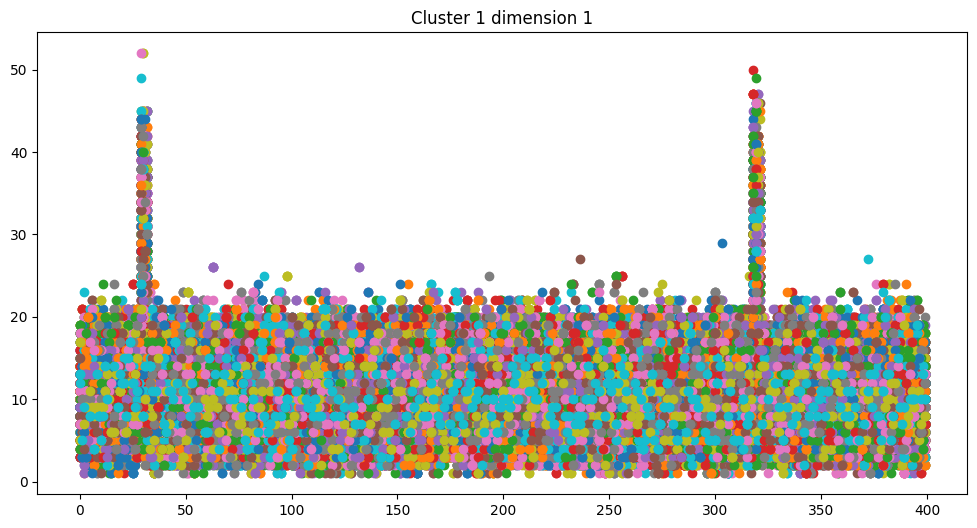

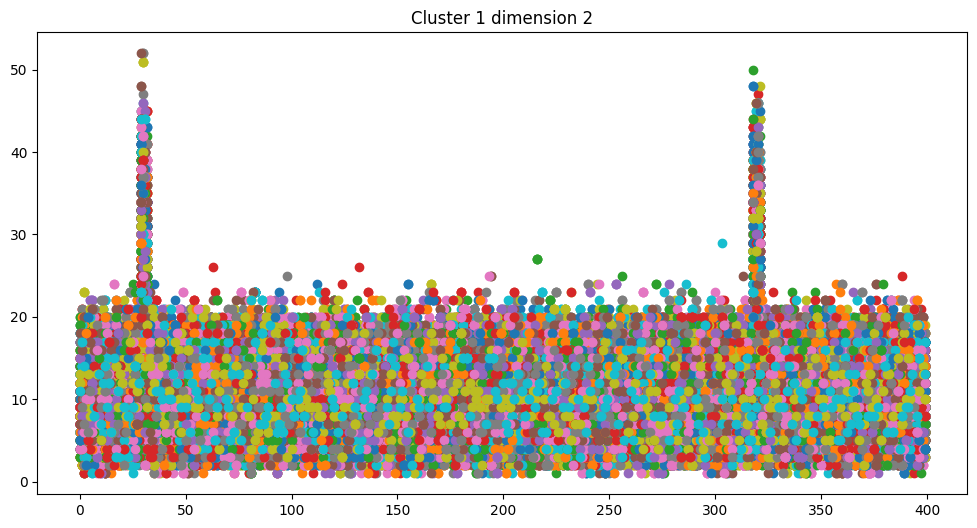

In [41]:
import matplotlib.pyplot as plt

for d in range(2):
    plt.figure(figsize=[12,6]) 
    for n in range(1000):
        plt.scatter(aug_data[1][n][aug_data[3][n]==d+1],aug_data[2][n][aug_data[3][n]==d+1])
    plt.title(f'Cluster 1 dimension {d+1}')
    plt.show()

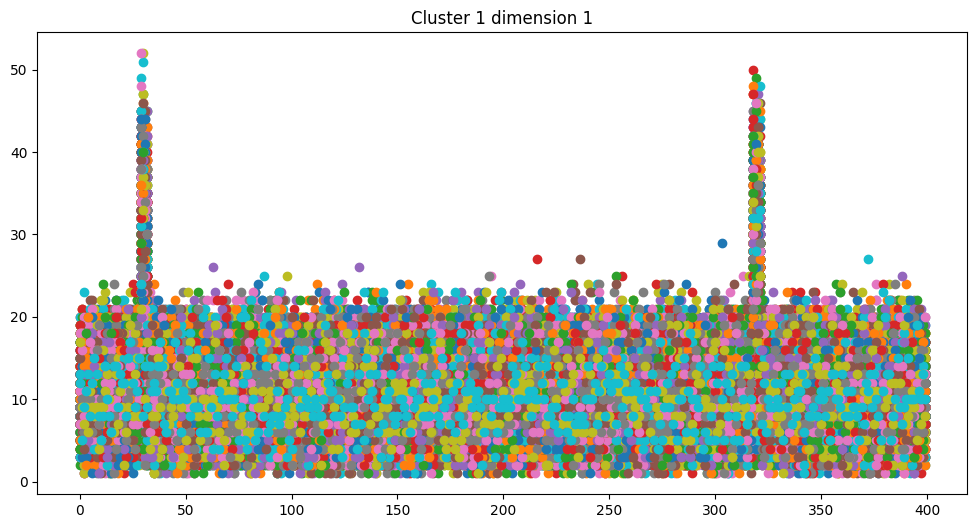

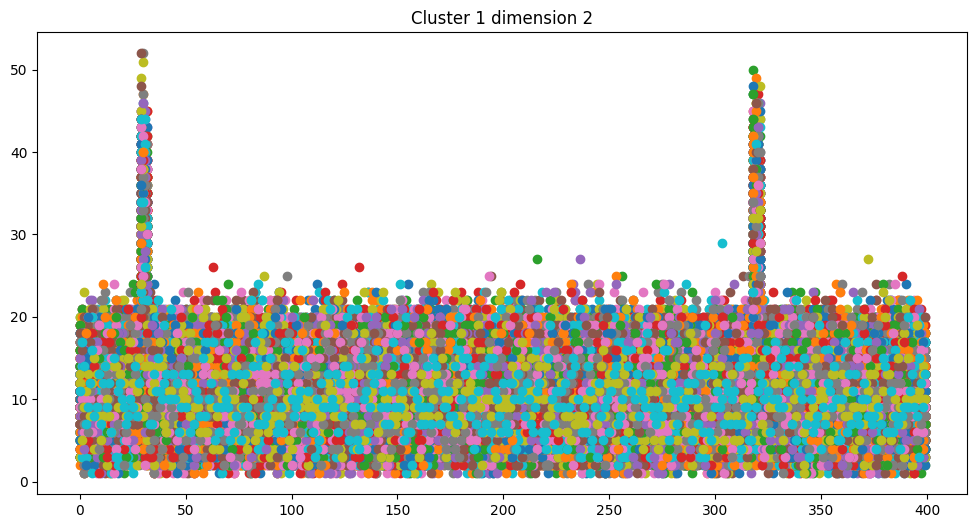

In [36]:
for d in range(2):
    plt.figure(figsize=[12,6]) 
    for n in range(1000):
        plt.scatter(data[1][n][data[3][n]==d+1],data[2][n][data[3][n]==d+1])
    plt.title(f'Cluster 1 dimension {d+1}')
    plt.show()

In [53]:
def tr_te_split(ts_data,aug_data,gt=None,tr_frac=0.8,seed=3):
    """
    Args:
        ts_data: list of lists [demo,timestamp_array,values_array,feat_dummy_array], each of these array shape (N * max_triplet_len)
        aug_data: augmented data, same format as ts_data
        gt_data: 1d np array of length N
    """
    # shuffle index and reorder based on the shuffle
    np.random.seed(seed)
    idx = np.arange(len(ts_data[0]))
    np.random.shuffle(idx)
    ts_data = [x[idx] for x in ts_data]
    aug_data = [x[idx] for x in aug_data]
    # partition into tr and te
    tr_data = [x[:int(tr_frac*len(ts_data[0]))] for x in ts_data]
    te_data = [x[int(tr_frac*len(ts_data[0])):] for x in ts_data]
    tr_aug_data = [x[:int(tr_frac*len(ts_data[0]))] for x in aug_data]
    te_aug_data = [x[int(tr_frac*len(ts_data[0])):] for x in aug_data]
    # partition ground truth
    if gt:
        gt = gt[idx]
        tr_gt = gt[:int(tr_frac*len(ts_data[0]))]
        te_gt = gt[int(tr_frac*len(ts_data[0])):]
    else:
        tr_gt, te_gt = None, None

    return (tr_data,tr_aug_data), tr_gt, (te_data,te_aug_data), te_gt

In [54]:
tr_data, tr_gt, val_data, val_gt = tr_te_split(data,aug_data,None,0.8,3)

In [68]:
tr_data[0][3].shape

(2400, 800)